In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, ZeroPadding2D, BatchNormalization, Input, Activation, Add, GlobalAveragePooling1D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import os
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version:", sys.version)
print("Tensorflow Version", tf.__version__)

Python Version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version 2.16.1


In [3]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Set only the first GPU device to be visible
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using only GPU device {physical_devices[0].name}\n")
else:
    print("No physical GPU devices found! \n")

# Verify GPU visibility in TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

No physical GPU devices found! 

GPU is not available


In [4]:
furniture_df = pd.read_csv("furniture_data.csv")

furniture_sliding_df = pd.read_csv("furniture_sliding_data.csv")

full_furniture_df = pd.concat([furniture_df, furniture_sliding_df], axis=0)

In [5]:
dev, test = train_test_split(furniture_df,train_size=0.85, shuffle=True, random_state=333)

In [6]:
dev.shape, test.shape

((76571, 3), (13513, 3))

In [7]:
#defined
BATCH_SIZE = 32

IMG_WIDTH  = 224
IMG_HEIGHT = 224

# For AlexNet
# IMG_WIDTH  = 227
# IMG_HEIGHT = 227

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator( rescale=1/255.0,
                                    rotation_range=40,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    brightness_range=[0.6, 1.2],
                                    fill_mode='nearest',
                                    validation_split=0.15,                      
                                    )

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [8]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image_Path',
    y_col='Furniture_Category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 65084 validated image filenames belonging to 6 classes.
Found 11485 validated image filenames belonging to 6 classes.
Found 13513 validated image filenames.


In [9]:
print(train_ds.class_indices)

{'beds': 0, 'chairs': 1, 'dressers': 2, 'lamps': 3, 'sofas': 4, 'tables': 5}


(32, 224, 224, 3)
(32, 6)
Label:  [0. 0. 1. 0. 0. 0.]


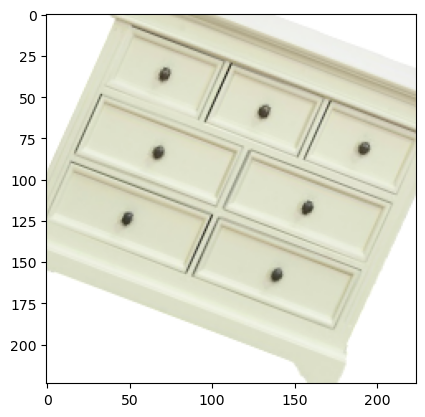

Label:  [0. 1. 0. 0. 0. 0.]


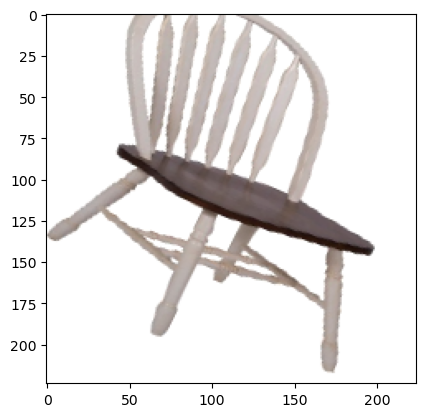

Label:  [0. 0. 0. 1. 0. 0.]


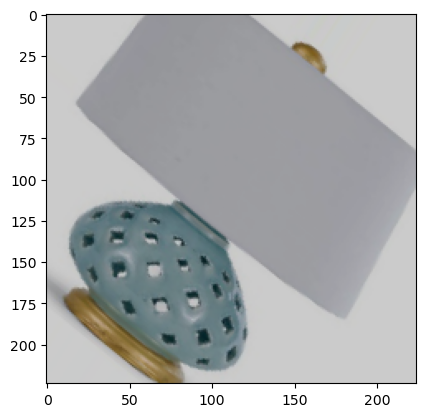

In [10]:
# Check image after data augmentation and normalization
batchX, batchY = train_ds.__next__()

print(batchX.shape)
print(batchY.shape)
for i in range(3):
    img = batchX[i]
    label = batchY[i]

    # print('Img: ', img)
    print('Label: ', label)

    plt.imshow(img)
    plt.show()

In [11]:
def identity_block(x, filters):
    x_skip = x
    
    x = Conv2D(filters[0], kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

def convolutional_block(x, filters, strides=(2, 2)):
    x_skip = x

    x = Conv2D(filters[0], kernel_size=(1, 1), strides=strides, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x_skip = Conv2D(filters[2], kernel_size=(1, 1), strides=strides, padding='valid')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

In [12]:
def ResNet50(shape=(224, 224, 3), classes=1000):
    x_input = Input(shape)
    x = ZeroPadding2D(padding=(3, 3))(x_input)

    # Stage 1
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Stage 2
    x = convolutional_block(x, filters=[64, 64, 256], strides=(1, 1))
    for _ in range(2):  # 3 - 1
        x = identity_block(x, filters=[64, 64, 256])

    # Stage 3
    x = convolutional_block(x, filters=[128, 128, 512])
    for _ in range(3):  # 4 - 1
        x = identity_block(x, filters=[128, 128, 512])

    # Stage 4
    x = convolutional_block(x, filters=[256, 256, 1024])
    for _ in range(5):  # 6 - 1 
        x = identity_block(x, filters=[256, 256, 1024])

    # Stage 5
    x = convolutional_block(x, filters=[512, 512, 2048])
    for _ in range(2):  # 3 - 1
        x = identity_block(x, filters=[512, 512, 2048])

    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=x, name="ResNet50")
    return model

In [13]:
# Adjust the 'classes' argument to match the number of classes in your dataset
resnet50_model = ResNet50(shape=(224, 224, 3), classes=6)  # Correct number of classes 
resnet50_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 112, 112, 64)      │           9,472 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 112, 112, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 112, 112, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 56, 56, 64)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 56, 56, 64)        │           4,160 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 56, 56, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 56, 56, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 56, 56, 64)        │          36,928 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 56, 56, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 56, 56, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 56, 56, 256)       │          16,640 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 56, 56, 256)       │          16,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 56, 56, 256)       │           1,024 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │               

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
# Adjust learning rate as needed
optimizer = Adam(learning_rate=0.001)
resnet50_model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(), 
    metrics=[CategoricalAccuracy()]
)

In [15]:
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,              # Stop if no improvement after 10 epochs
    restore_best_weights=True, # Restore weights with best performance
    verbose=1,                
    min_delta=0.0001,
)

In [ ]:
# Replace 'train_ds' and 'val_ds' with your actual training and validation datasets
# Adjust batch size and epochs as needed
history = resnet50_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=50,               
    batch_size=32, 
    callbacks=[early_stopping_callback] 
)

Epoch 1/50
  78/2034 ━━━━━━━━━━━━━━━━━━━━ 3:49:03 7s/step - categorical_accuracy: 0.3461 - loss: 2.6668